In [1]:
#Standard python imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

#Stats imports
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.stats.multicomp as mc
import scipy.stats as stats

#random seed for replicability
np.random.seed(seed=42)

In [14]:
bos_df = pd.read_csv('../data/bos_df_cleaned.csv')
bos_df.head(2)

,severity,start_lat,start_lng,end_lat,end_lng,distance(mi),temperature(f),wind_chill(f),humidity(%),pressure(in),...,hour_23,weather_condition_Light Snow with Thunder,weather_condition_Smoke / Windy,weather_condition_Light Thunderstorms and Snow,weather_condition_Haze / Windy,weather_condition_Freezing Rain,weather_condition_Heavy Snow / Windy,weather_condition_Blowing Dust / Windy,weather_condition_Heavy Blowing Snow,is_DST
0,2,41.879630,-71.377990,41.885180,-71.378500,0.384,46.9,46.9,97.0,30.01,...,0,0,0,0,0,0,0,0,0,0
1,2,42.619594,-71.125395,42.610934,-71.123411,0.607,45.0,40.6,97.0,29.98,...,0,0,0,0,0,0,0,0,0,0


## ANOVA on severity of accidents for Spring DST Time Change

In [11]:
#I (CH) referenced this article for a refresher on ANOVA and to find the libraries to use for each test
#https://www.pythonfordatascience.org/anova-python/#anova-test
#I referenced these pages for a refresher on ANOVA vs. Kruskall-Wallace and the impact of a non-normal distribution
# https://stats.stackexchange.com/questions/76059/difference-between-anova-and-kruskal-wallis-test
# http://www.biostathandbook.com/kruskalwallis.html

In [3]:
#Overall comparison of week before, week of DST, and week after DST for traffic accidents in chicago
stats.f_oneway(bos_df['severity'][bos_df['week'] == 10],
              bos_df['severity'][bos_df['week'] == 11],
              bos_df['severity'][bos_df['week'] == 12])

F_onewayResult(statistic=5.9963964014541, pvalue=0.0026058413958592644)

In [15]:
bos_df_spring_dst =  bos_df[(bos_df['week'] == 10) | (bos_df['week'] == 11) | (bos_df['week'] == 12)]
bos_df_spring_dst.head(2)

,severity,start_lat,start_lng,end_lat,end_lng,distance(mi),temperature(f),wind_chill(f),humidity(%),pressure(in),...,hour_23,weather_condition_Light Snow with Thunder,weather_condition_Smoke / Windy,weather_condition_Light Thunderstorms and Snow,weather_condition_Haze / Windy,weather_condition_Freezing Rain,weather_condition_Heavy Snow / Windy,weather_condition_Blowing Dust / Windy,weather_condition_Heavy Blowing Snow,is_DST
1310,2,41.86973,-71.43105,41.86720,-71.43071,0.176,48.2,48.2,54.0,29.89,...,0,0,0,0,0,0,0,0,0,0
1311,2,41.82600,-71.42131,41.82496,-71.41994,0.101,50.0,50.0,57.0,29.91,...,0,0,0,0,0,0,0,0,0,0


In [17]:
bos_df_spring_dst['week'].value_counts()

10    467
12    430
11    362
Name: week, dtype: int64

In [5]:
bos_spring_anova = ols("severity ~C(week)", data=bos_df_spring_dst).fit()
bos_aov_table = sm.stats.anova_lm(bos_spring_anova, typ=2)
bos_aov_table

,sum_sq,df,F,PR(>F)
C(week),4.205904,2.0,5.996396,0.002606
Residual,268.988901,767.0,NaN,NaN


In [7]:
#Shapiro test of normality, failed as the severity of accidents is not normally distributed
stats.shapiro(bos_spring_anova.resid)

ShapiroResult(statistic=0.7862808704376221, pvalue=1.4826542220367855e-30)

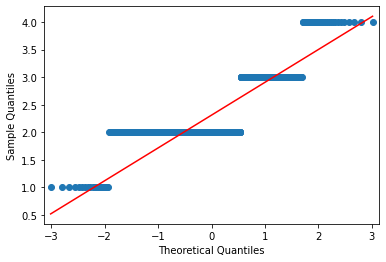

In [8]:
#QQ plot to conform lack of normality
sm.qqplot(bos_df_spring_dst['severity'], line='s');

In [9]:
#Levene's test of 
stats.levene(bos_df['severity'][bos_df['week'] == 10],
              bos_df['severity'][bos_df['week'] == 11],
              bos_df['severity'][bos_df['week'] == 12])

LeveneResult(statistic=12.902983092700469, pvalue=3.079726801873145e-06)

In [10]:
stats.kruskal(bos_df['severity'][bos_df['week'] == 10],
              bos_df['severity'][bos_df['week'] == 11],
              bos_df['severity'][bos_df['week'] == 12])

KruskalResult(statistic=19.8524490436548, pvalue=4.887597838129943e-05)

### Tukey Honestly Significant Difference (HSD) Test

In [16]:
bos_df_spring_dst['week'] = bos_df_spring_dst.week.map({10 : 'Week Before', 11 : 'Week of DST', 12: 'Week After'})
bos_df_spring_dst['week']

<ipython-input-16-c45d8be80751>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bos_df_spring_dst['week'] = bos_df_spring_dst.week.map({10 : 'Week Before', 11 : 'Week of DST', 12: 'Week After'})


1310    Week After
1311    Week After
1312    Week After
1313    Week After
1314    Week After
           ...    
9774    Week After
9775    Week After
9776    Week After
9777    Week After
9778    Week After
Name: week, Length: 770, dtype: object

In [17]:
bos_df_spring_dst['week'].value_counts()

Week After     301
Week of DST    273
Week Before    196
Name: week, dtype: int64

In [18]:
comp = mc.MultiComparison(bos_df_spring_dst['severity'], bos_df_spring_dst['week'], 
                         group_order=['Week Before', 'Week of DST', 'Week After'])
post_hoc = comp.tukeyhsd()
post_hoc.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Week Before,Week of DST,0.1907,0.0018,0.0605,0.3209,True
Week Before,Week After,0.1284,0.0483,0.0007,0.256,True
Week of DST,Week After,-0.0624,0.4202,-0.1786,0.0539,False


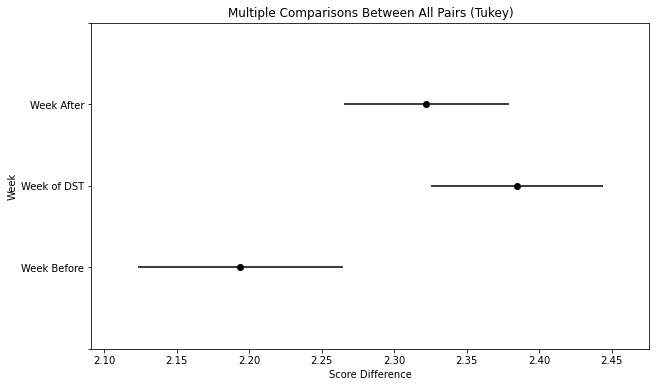

In [19]:
post_hoc.plot_simultaneous(ylabel='Week', xlabel='Score Difference');

### Bonferroni Correction

In [20]:
tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method='bonf')
tbl

group1,group2,stat,pval,pval_corr,reject
Week Before,Week of DST,-3.4249,0.0007,0.002,True
Week Before,Week After,-2.4728,0.0137,0.0412,True
Week of DST,Week After,1.2188,0.2234,0.6703,False


In [47]:
chi_df_spring_dst.groupby('week').mean()

,severity,start_lat,start_lng,end_lat,end_lng,distance(mi),temperature(f),wind_chill(f),humidity(%),pressure(in),...,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,weather_condition_Light Snow and Sleet,is_DST
week,,,,,,,,,,,,,,,,,,,,,
10,2.759259,41.971090,-87.844087,41.971160,-87.844042,0.378793,41.404630,36.361667,61.195683,29.898611,...,0.107407,0.118519,0.074074,0.027778,0.020370,0.014815,0.029630,0.027778,0.0,0.644444
11,2.626362,41.956557,-87.859411,41.956819,-87.859643,0.278264,34.605338,27.270479,73.103486,30.017669,...,0.080610,0.071895,0.049020,0.033769,0.021786,0.025054,0.028322,0.028322,0.0,0.464052
12,2.697479,41.938544,-87.859321,41.938944,-87.859486,0.228887,44.143137,40.588095,70.200280,29.822913,...,0.078431,0.060224,0.050420,0.023810,0.022409,0.028011,0.019608,0.036415,0.0,0.000000


### Sidak Correction 

In [21]:
tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method='sidak')
tbl

group1,group2,stat,pval,pval_corr,reject
Week Before,Week of DST,-3.4249,0.0007,0.002,True
Week Before,Week After,-2.4728,0.0137,0.0407,True
Week of DST,Week After,1.2188,0.2234,0.5317,False


### Interpretation

* Based on the results of the ANOVA and Kruskall-Wallace tests we can see that there is a significant difference in the severity of traffic accidents before, during the week of DST, and after the week of DST.
* Interestingly in Atlanta we saw a difference in the week before DST and the week after DST and the week of DST and the week after DST. 